In [1]:

import os
import pickle
import tarfile
import random

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import optuna


from fastprogress import master_bar, progress_bar
from fastprogress.fastprogress import master_bar, progress_bar  


torch.set_default_dtype(torch.float32)
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.backends.mps.is_available():
    torch.mps.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


import warnings
warnings.filterwarnings('ignore')

In [2]:
cifar10_labels = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
] 

In [3]:


class CIFAR10DataLoader:
    def __init__(self, tar_path, destination='./', val_size=0.2):
        self.tar_path = tar_path
        self.destination = destination
        self.val_size = val_size
        self.directory = os.path.join(destination, 'cifar-10-batches-py')
        self.X_train, self.y_train, self.X_val, self.y_val, self.X_test, self.y_test = self.prepare_data()

    def extract_archive(self):
        with tarfile.open(self.tar_path) as tar:
            tar.extractall(path=self.destination)
                

    def load_batch_from_file(self, file):
        with open(file, 'rb') as f:
            data = pickle.load(f, encoding='bytes')
            img = data[b'data']
            label = data[b'labels']
            img = img.reshape(-1, 3, 32, 32)
            img = img.transpose(0, 2, 3, 1).astype("float")
            label = np.array(label)
            return img, label

    def load_all_data_batches(self):
        X_train = np.concatenate([self.load_batch_from_file(os.path.join(self.directory, f'data_batch_{i}'))[0] for i in range(1, 6)])
        y_train = np.concatenate([self.load_batch_from_file(os.path.join(self.directory, f'data_batch_{i}'))[1] for i in range(1, 6)])
        X_test, y_test = self.load_batch_from_file(os.path.join(self.directory, 'test_batch'))
        return X_train, y_train, X_test, y_test

    def split_train_validation(self, X_train, y_train):
        return train_test_split(
            X_train, y_train, test_size=self.val_size, random_state=42, stratify=y_train
        )

    def prepare_data(self):
        self.extract_archive()
        X_train, y_train, X_test, y_test = self.load_all_data_batches()
        X_train_new, X_val, y_train_new, y_val = self.split_train_validation(X_train, y_train)
        return X_train_new, y_train_new, X_val, y_val, X_test, y_test



tar_path = './cifar-10-python.tar.gz' 
destination = './'  
load_cifar = CIFAR10DataLoader(tar_path=tar_path, destination=destination, val_size=0.2)
X_train, Y_train = load_cifar.X_train, load_cifar.y_train
X_val, Y_val = load_cifar.X_val, load_cifar.y_val
X_test, Y_test = load_cifar.X_test, load_cifar.y_test

print(f"Training data shape  X: {X_train.shape}, y: {Y_train.shape} ")
print(f"Validation data shape X : {X_val.shape}, y:{Y_val.shape} ")
print(f"Test data shape X : {X_test.shape}, y:{Y_test.shape} ")



Training data shape  X: (40000, 32, 32, 3), y: (40000,) 
Validation data shape X : (10000, 32, 32, 3), y:(10000,) 
Test data shape X : (10000, 32, 32, 3), y:(10000,) 


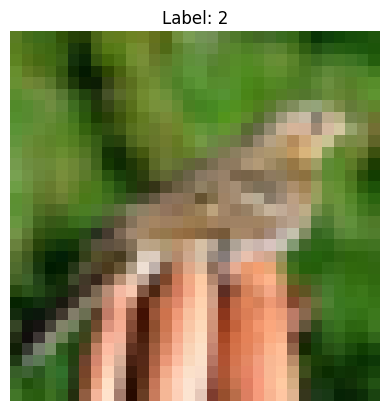

In [4]:
image = X_train[4].astype("uint8")
label = Y_train[4]
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

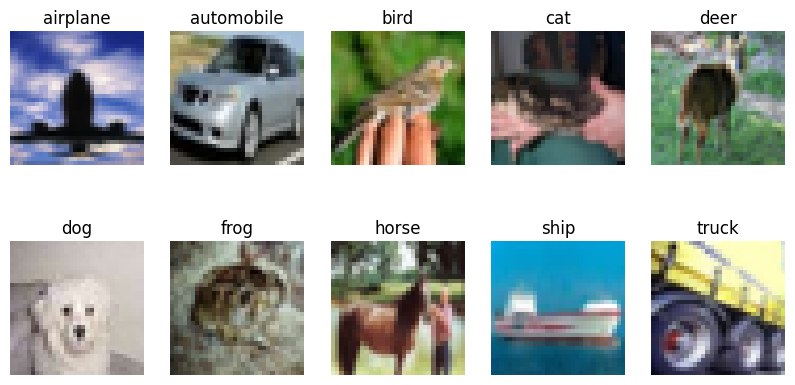

In [5]:
# loading images from each class
unique_labels, first_occurrence_indices = np.unique(Y_train, return_index=True)
sorted_indices = np.argsort(unique_labels)
plt.figure(figsize=(10, 5)) 
for i, idx in enumerate(first_occurrence_indices[sorted_indices]):
    image = X_train[idx]
    label_name = cifar10_labels[Y_train[idx]]
    plt.subplot(2, 5, i + 1)
    plt.imshow(image.astype('uint8'))  
    plt.title(f"{label_name}")
    plt.axis('off')  

plt.show()

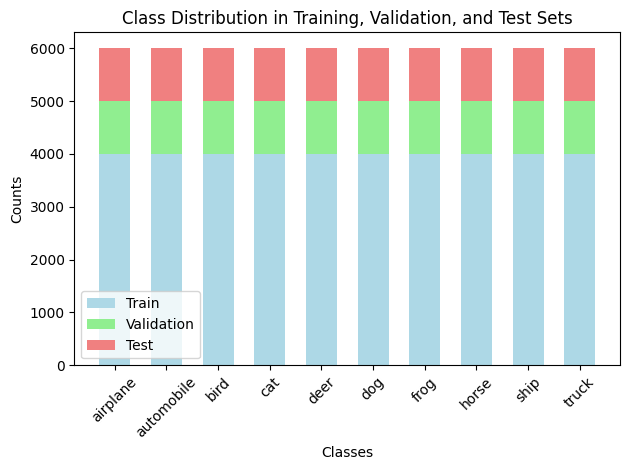

In [6]:
# plot train, val, test

num_classes = 10


train_counts = np.bincount(Y_train, minlength=num_classes)
val_counts = np.bincount(Y_val, minlength=num_classes)
test_counts = np.bincount(Y_test, minlength=num_classes)

cifar10_labels = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
] 

x = np.arange(num_classes)  
width = 0.6  

fig, ax = plt.subplots()


ax.bar(x, train_counts, width, label='Train', color='lightblue')
ax.bar(x, val_counts, width, bottom=train_counts, label='Validation', color='lightgreen')
ax.bar(x, test_counts, width, bottom=train_counts + val_counts, label='Test', color='lightcoral')


ax.set_xlabel('Classes')
ax.set_ylabel('Counts')
ax.set_title('Class Distribution in Training, Validation, and Test Sets')
ax.set_xticks(x)
ax.set_xticklabels(cifar10_labels)
ax.legend()


plt.xticks(rotation=45) 
plt.tight_layout()  
plt.show()


In [7]:
# preprocessing
mean = np.mean(X_train, axis=(0, 1, 2)) / 255.0
std = np.std(X_train, axis=(0, 1, 2)) / 255.0
transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(32, padding=1),  
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  
])


transform_val_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


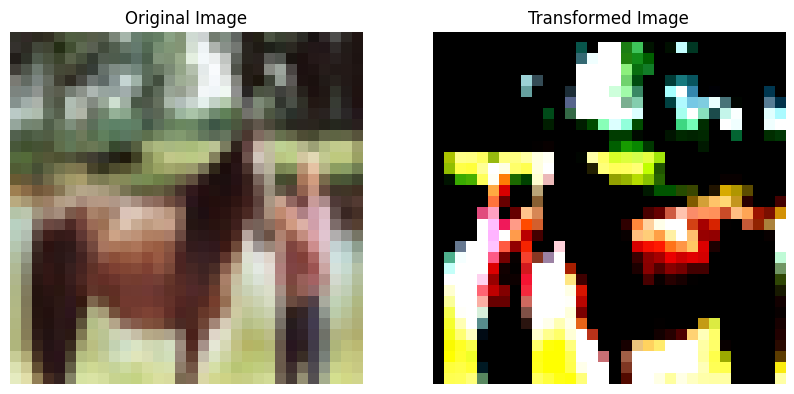

In [8]:
#train set transformation
idx = 1

image = X_train[idx].astype("uint8")
transformed_image = transform_train(image)
original_image_display = transforms.ToTensor()(image)
transformed_image_display = transformed_image
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(original_image_display.permute(1, 2, 0))
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(transformed_image_display.permute(1, 2, 0))
axs[1].set_title("Transformed Image")
axs[1].axis("off")

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


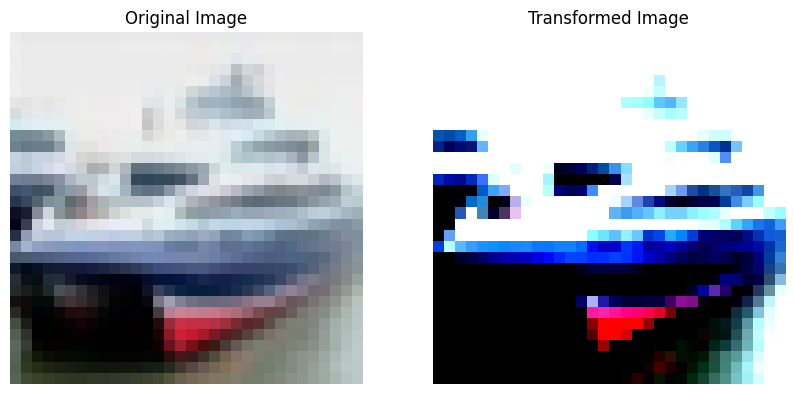

In [9]:
#val & test set transformation

image = X_test[idx].astype("uint8")
transformed_image = transform_val_test(image)


original_image_display = transforms.ToTensor()(image)
transformed_image_display = transformed_image

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(original_image_display.permute(1, 2, 0))
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(transformed_image_display.permute(1, 2, 0))
axs[1].set_title("Transformed Image")
axs[1].axis("off")

plt.show()

In [10]:
# loading CIFAR 10 data
class CustomDataset(Dataset):
    def __init__(self, X_data, y_data, transform=None):
        self.X_data = X_data
        self.y_data = y_data
        self.transform = transform
        

    def __len__(self):
        return len(self.y_data)

    def __getitem__(self, idx):
        image = self.X_data[idx].astype(np.uint8)
        label = self.y_data[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


train_dataset = CustomDataset(X_train, Y_train, transform=transform_train)
test_dataset = CustomDataset(X_test, Y_test, transform=transform_val_test)
val_dataset = CustomDataset(X_val,Y_val, transform = transform_val_test )

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0)

In [39]:
def plot_loss_curves(metrics):

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    train_loss = metrics['train_loss']
    val_loss = metrics['val_loss']
    train_acc = metrics['train_accuracy']
    val_acc = metrics['val_accuracy']
    axes[0].set_title(f'Training & Validation Loss')
    axes[0].plot(train_loss, label='training loss', color='red')
    axes[0].plot(val_loss, label='validation loss', color='blue')
    axes[0].grid()
    axes[0].legend()
    axes[1].set_title(f'Training & Validation Accuracy')
    axes[1].plot(train_acc, label='train accuracy', color='red')
    axes[1].plot(val_acc, label='validation accuracy', color='blue')
    axes[1].grid()
    axes[1].legend()
    plt.tight_layout()
    plt.show()

In [12]:
# setting device
device = torch.device("mps")

In [13]:
# test set evalute
def evaluate_models(model):
    """ Loads model and evaluates in test data

    Args:
        model (torch.nn.Module): The model to be evaluated.
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / total * 100
    print(f"Test Accuracy: {test_accuracy:.2f}%")

In [14]:
# resnet18 model
resnet18 = models.resnet18(weights=False)
input_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(input_features, 10) 
resnet18 = resnet18.to(device)


In [15]:
# main training loop
def run_training(model, epochs, train_loader, validation_loader, optimizer, criterion, device, scheduler=None, patience=10):

    training_loss = []
    validation_loss = []
    train_accuracy = []
    validation_accuracy = []
    best_val_loss = float('inf')
    
    patience_counter = 0 
    best_model_weights = model.state_dict() 

   
    mb = master_bar(range(epochs))

    for epoch in mb:
        model.train() 
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        pb = progress_bar(enumerate(train_loader, 0), parent=mb, total=len(train_loader))

        for i, data in pb:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            final_op = torch.argmax(outputs, dim=1)
            correct_predictions += torch.sum(final_op == labels).item()
            total_predictions += len(labels)

            if i % 200 == 199: 
                mb.child.comment = f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}'

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_accuracy = correct_predictions / total_predictions
        training_loss.append(epoch_train_loss)
        train_accuracy.append(epoch_train_accuracy)

       
        model.eval()  
        correct_val_predictions = 0
        total_val_predictions = 0
        val_loss = 0.0
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()
                val_final_op = torch.argmax(val_outputs, dim=1)
                correct_val_predictions += torch.sum(val_final_op == val_labels).item()
                total_val_predictions += len(val_labels)

        epoch_val_loss = val_loss / len(validation_loader)
        epoch_val_accuracy = correct_val_predictions / total_val_predictions
        validation_loss.append(epoch_val_loss)
        validation_accuracy.append(epoch_val_accuracy)

        
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(epoch_val_loss)  
            else:
                scheduler.step() 

        
        mb.write(f'Epoch {epoch+1} | Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f} | '
                 f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f}')
        
       
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0  
            best_model_weights = model.state_dict()  
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after at epoch: {epoch + 1} ")
            break

    
    model.load_state_dict(best_model_weights)


   
    return model, {
        'train_loss': training_loss,
        'val_loss': validation_loss,
        'train_accuracy': train_accuracy,
        'val_accuracy': validation_accuracy,
    }


## Resnet 18 with SGD Optimizer 

Early stopping triggered after at epoch: 24 


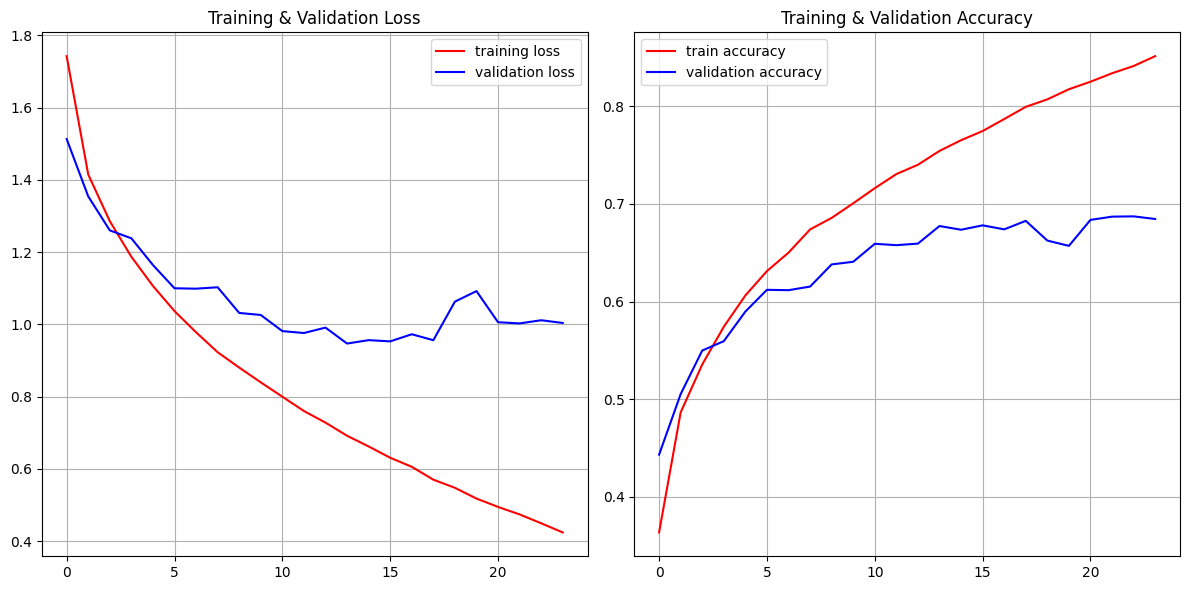

In [16]:
# ResNet18 + SGD

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.01)
model , base_line_metrics = run_training(resnet18, 
                               epochs=30, 
                               train_loader=train_loader, 
                               validation_loader=val_loader,
                               optimizer=optimizer, 
                               criterion=criterion, 
                               device=device,
                               patience = 10)

torch.save(model.state_dict(), 'resnet18_baseline_model.pth')                          
plot_loss_curves(base_line_metrics)


In [17]:
# ResNet18 + SGD evaluation
model = models.resnet18(pretrained=False)  
model.fc = nn.Linear(model.fc.in_features, 10)  
model.load_state_dict(torch.load('resnet18_baseline_model.pth')) 
model = model.to(device)
evaluate_models(model)

Test Accuracy: 68.15%


## RESNET 18 Adam Optimizer

Early stopping triggered after at epoch: 29 


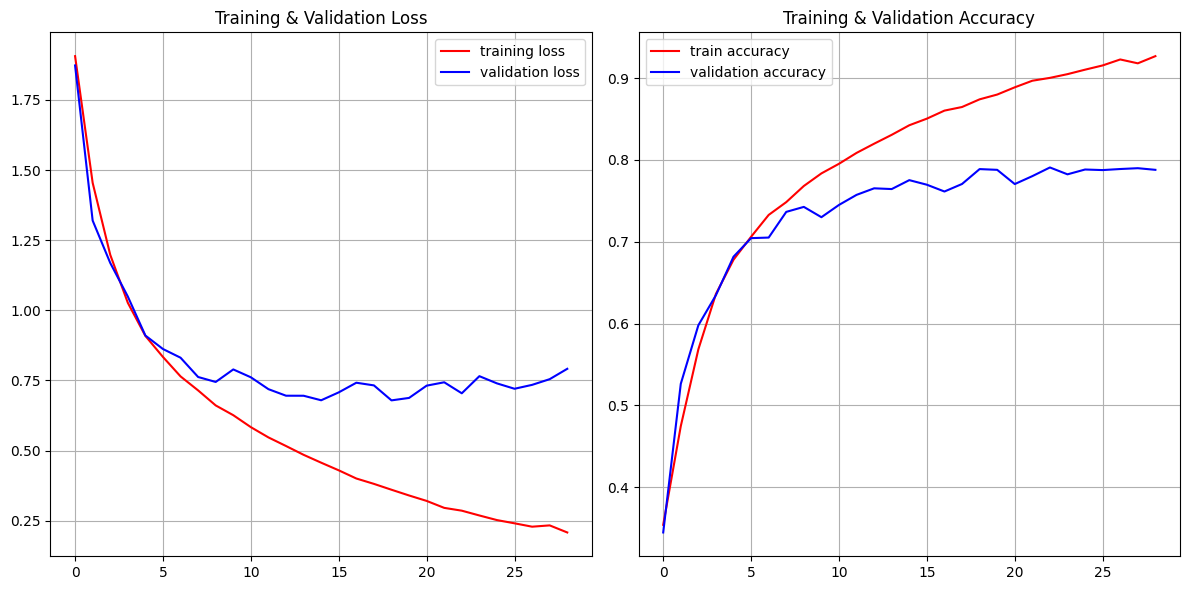

In [18]:
# resnet 18 + Adam optimizer 

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.01)
model , base_line_metrics = run_training(resnet18, 
                               epochs=30, 
                               train_loader=train_loader, 
                               validation_loader=val_loader,
                               optimizer=optimizer, 
                               criterion=criterion, 
                               device=device,
                               patience = 10)

torch.save(model.state_dict(), 'resnet18_Adam_baseline_model.pth')                               
plot_loss_curves(base_line_metrics)

In [19]:
# resnet 18 + Adam optimizer evaluation
model = models.resnet18(pretrained=False)  
model.fc = nn.Linear(model.fc.in_features, 10)  
model.load_state_dict(torch.load('resnet18_Adam_baseline_model.pth')) 
model = model.to(device)
evaluate_models(model)

Test Accuracy: 78.79%


## RESNET 18 with Adam Optimizer finetuning using Bayesian optimization

In [20]:
# Resnet18 finetune function
def resnet18_finetune_objective(trial, model_save_dir):
    
    model = models.resnet18(pretrained=False)  
    model.fc = nn.Linear(model.fc.in_features, 10)  
    model.load_state_dict(torch.load('resnet18_Adam_baseline_model.pth')) 
    model = model.to(device)

    learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

   
    trained_model, metrics = run_training(
        model=model,
        epochs=10,  
        train_loader=train_loader,
        validation_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=device,
        patience=5,
    )

 
    val_accuracy = metrics['val_accuracy'][-1]

    if val_accuracy > resnet18_finetune_objective.best_accuracy:
        resnet18_finetune_objective.best_accuracy = val_accuracy
        best_model_path = os.path.join(model_save_dir, f"best_model_trial_{trial.number}.pth")
        torch.save(trained_model.state_dict(), best_model_path)  
        resnet18_finetune_objective.best_model_path = best_model_path  
    
    return val_accuracy


In [21]:
# ResNet18 initalise finetune
resnet18_finetune_objective.best_accuracy = base_line_metrics['val_accuracy'][-1]
resnet18_finetune_objective.best_model_path = None  


model_dir = "./resnet18_bestmodel_trials_Adam"  
os.makedirs(model_dir, exist_ok=True) 

study = optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(lambda trial: resnet18_finetune_objective(trial = trial, model_save_dir=model_dir), n_trials=10)

[I 2024-11-06 22:10:05,427] A new study created in memory with name: no-name-e70922e7-e39d-4300-acb1-f453f6c17071


[I 2024-11-06 22:12:48,507] Trial 0 finished with value: 0.7822 and parameters: {'lr': 0.00031489116479568613, 'weight_decay': 0.0071144760093434225}. Best is trial 0 with value: 0.7822.


Early stopping triggered after at epoch: 8 


[I 2024-11-06 22:15:51,319] Trial 1 finished with value: 0.6473 and parameters: {'lr': 0.008471801418819975, 'weight_decay': 0.0006251373574521745}. Best is trial 0 with value: 0.7822.


Early stopping triggered after at epoch: 9 


[I 2024-11-06 22:19:13,724] Trial 2 finished with value: 0.8154 and parameters: {'lr': 4.207988669606632e-05, 'weight_decay': 2.9375384576328295e-05}. Best is trial 2 with value: 0.8154.


[I 2024-11-06 22:22:37,113] Trial 3 finished with value: 0.8013 and parameters: {'lr': 1.7073967431528103e-05, 'weight_decay': 0.003967605077052989}. Best is trial 2 with value: 0.8154.


[I 2024-11-06 22:24:38,620] Trial 4 finished with value: 0.7133 and parameters: {'lr': 0.002537815508265664, 'weight_decay': 0.001331121608073689}. Best is trial 2 with value: 0.8154.


Early stopping triggered after at epoch: 6 


[I 2024-11-06 22:28:01,865] Trial 5 finished with value: 0.7986 and parameters: {'lr': 1.2087541473056957e-05, 'weight_decay': 0.008123245085588688}. Best is trial 2 with value: 0.8154.


[I 2024-11-06 22:30:04,694] Trial 6 finished with value: 0.6669 and parameters: {'lr': 0.02136832907235875, 'weight_decay': 4.335281794951564e-05}. Best is trial 2 with value: 0.8154.


Early stopping triggered after at epoch: 6 


[I 2024-11-06 22:33:28,366] Trial 7 finished with value: 0.8151 and parameters: {'lr': 5.3370327626039544e-05, 'weight_decay': 3.5498788321965036e-05}. Best is trial 2 with value: 0.8154.


[I 2024-11-06 22:36:32,075] Trial 8 finished with value: 0.8146 and parameters: {'lr': 0.00016480446427978953, 'weight_decay': 0.00037520558551242813}. Best is trial 2 with value: 0.8154.


Early stopping triggered after at epoch: 9 


[I 2024-11-06 22:38:35,820] Trial 9 finished with value: 0.8217 and parameters: {'lr': 0.0005342937261279771, 'weight_decay': 7.476312062252303e-05}. Best is trial 9 with value: 0.8217.


Early stopping triggered after at epoch: 6 


In [22]:
# finetuned ResNet18 evaluation

model = models.resnet18(pretrained=False)  
model.fc = nn.Linear(model.fc.in_features, 10)  
model.load_state_dict(torch.load(resnet18_finetune_objective.best_model_path)) 
model = model.to(device)
evaluate_models(model)



Test Accuracy: 81.33%


## shuffle net 

In [23]:
# ShuffleNet baseline + Adam
shufflenet = torch.hub.load('pytorch/vision:v0.10.0', 'shufflenet_v2_x1_0', pretrained='False')
shufflenet.fc = nn.Linear(shufflenet.fc.in_features, 10) 
shufflenet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(shufflenet.parameters(), lr=0.01)
shufflenet, shufflenet_performance = run_training(
    model=shufflenet, 
    epochs=30, 
    train_loader=train_loader, 
    validation_loader=val_loader,
    optimizer=optimizer, 
    criterion=criterion, 
    device=device,
    patience=10
)
torch.save(shufflenet.state_dict(), 'shufflenet_Adam_baseline_model.pth')

Using cache found in /Users/nivedhithamuruganandam/.cache/torch/hub/pytorch_vision_v0.10.0


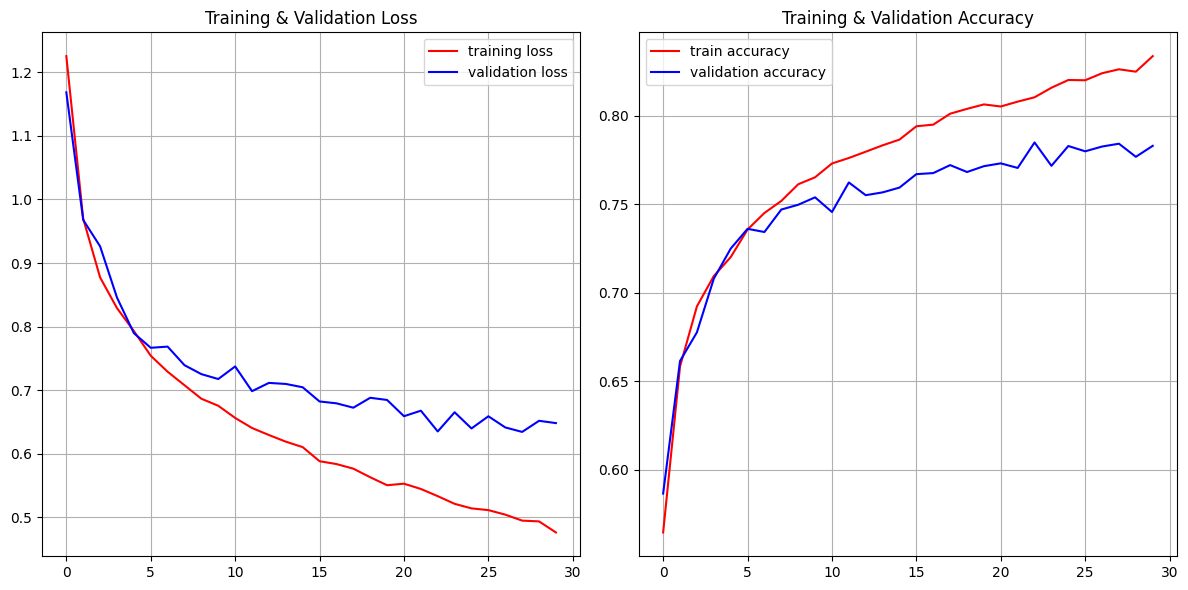

In [24]:
# ShuffleNet training curves
plot_loss_curves(shufflenet_performance)

In [25]:
# shuffleNet baseline evaluation
model =torch.hub.load('pytorch/vision:v0.10.0', 'shufflenet_v2_x1_0', pretrained='False') 
model.fc = nn.Linear(model.fc.in_features, 10)  
model.load_state_dict(torch.load('shufflenet_Adam_baseline_model.pth')) 
model = model.to(device)
evaluate_models(model)

Using cache found in /Users/nivedhithamuruganandam/.cache/torch/hub/pytorch_vision_v0.10.0


Test Accuracy: 77.55%


In [26]:
# shuffleNet finetuning
def shufflenet_finetune_objective(trial, model_save_dir):
    
    model =torch.hub.load('pytorch/vision:v0.10.0', 'shufflenet_v2_x1_0', pretrained='False') 
    model.fc = nn.Linear(model.fc.in_features, 10)  
    model.load_state_dict(torch.load('shufflenet_Adam_baseline_model.pth')) 
    model = model.to(device)

    learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

 
    trained_model, metrics = run_training(
        model=model,
        epochs=10,  
        train_loader=train_loader,
        validation_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=device,
        patience=5,
    )

    
    val_accuracy = metrics['val_accuracy'][-1]
    if val_accuracy > shufflenet_finetune_objective.best_accuracy:
        shufflenet_finetune_objective.best_accuracy = val_accuracy
        best_model_path = os.path.join(model_save_dir, f"best_model_trial_{trial.number}.pth")
        torch.save(trained_model.state_dict(), best_model_path)  
        shufflenet_finetune_objective.best_model_path = best_model_path  
    
    return val_accuracy


In [27]:
# initialize shufflenet finetune
shufflenet_finetune_objective.best_accuracy = shufflenet_performance['val_accuracy'][-1]
shufflenet_finetune_objective.best_model_path = None  


model_dir = "./shufflenet_bestmodel_trials_Adam"  
os.makedirs(model_dir, exist_ok=True) 

study = optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(lambda trial: shufflenet_finetune_objective(trial = trial, model_save_dir=model_dir), n_trials=10)

[I 2024-11-06 22:54:33,063] A new study created in memory with name: no-name-d7fde2ea-41e5-43c8-b93e-eb1aed23b76c
Using cache found in /Users/nivedhithamuruganandam/.cache/torch/hub/pytorch_vision_v0.10.0


[I 2024-11-06 22:57:57,348] Trial 0 finished with value: 0.7664 and parameters: {'lr': 0.00031489116479568613, 'weight_decay': 0.0071144760093434225}. Best is trial 0 with value: 0.7664.


Early stopping triggered after at epoch: 6 


Using cache found in /Users/nivedhithamuruganandam/.cache/torch/hub/pytorch_vision_v0.10.0


[I 2024-11-06 23:01:21,994] Trial 1 finished with value: 0.6619 and parameters: {'lr': 0.008471801418819975, 'weight_decay': 0.0006251373574521745}. Best is trial 0 with value: 0.7664.


Early stopping triggered after at epoch: 6 


Using cache found in /Users/nivedhithamuruganandam/.cache/torch/hub/pytorch_vision_v0.10.0


[I 2024-11-06 23:07:03,285] Trial 2 finished with value: 0.8056 and parameters: {'lr': 4.207988669606632e-05, 'weight_decay': 2.9375384576328295e-05}. Best is trial 2 with value: 0.8056.
Using cache found in /Users/nivedhithamuruganandam/.cache/torch/hub/pytorch_vision_v0.10.0


[I 2024-11-06 23:12:46,117] Trial 3 finished with value: 0.8004 and parameters: {'lr': 1.7073967431528103e-05, 'weight_decay': 0.003967605077052989}. Best is trial 2 with value: 0.8056.
Using cache found in /Users/nivedhithamuruganandam/.cache/torch/hub/pytorch_vision_v0.10.0


[I 2024-11-06 23:16:11,671] Trial 4 finished with value: 0.7541 and parameters: {'lr': 0.002537815508265664, 'weight_decay': 0.001331121608073689}. Best is trial 2 with value: 0.8056.


Early stopping triggered after at epoch: 6 


Using cache found in /Users/nivedhithamuruganandam/.cache/torch/hub/pytorch_vision_v0.10.0


[I 2024-11-06 23:21:57,678] Trial 5 finished with value: 0.7973 and parameters: {'lr': 1.2087541473056957e-05, 'weight_decay': 0.008123245085588688}. Best is trial 2 with value: 0.8056.
Using cache found in /Users/nivedhithamuruganandam/.cache/torch/hub/pytorch_vision_v0.10.0


[I 2024-11-06 23:25:23,073] Trial 6 finished with value: 0.6952 and parameters: {'lr': 0.02136832907235875, 'weight_decay': 4.335281794951564e-05}. Best is trial 2 with value: 0.8056.


Early stopping triggered after at epoch: 6 


Using cache found in /Users/nivedhithamuruganandam/.cache/torch/hub/pytorch_vision_v0.10.0


[I 2024-11-06 23:31:07,098] Trial 7 finished with value: 0.8061 and parameters: {'lr': 5.3370327626039544e-05, 'weight_decay': 3.5498788321965036e-05}. Best is trial 7 with value: 0.8061.
Using cache found in /Users/nivedhithamuruganandam/.cache/torch/hub/pytorch_vision_v0.10.0


[I 2024-11-06 23:36:51,914] Trial 8 finished with value: 0.8068 and parameters: {'lr': 0.00016480446427978953, 'weight_decay': 0.00037520558551242813}. Best is trial 8 with value: 0.8068.
Using cache found in /Users/nivedhithamuruganandam/.cache/torch/hub/pytorch_vision_v0.10.0


[I 2024-11-06 23:40:54,071] Trial 9 finished with value: 0.8108 and parameters: {'lr': 0.0005342937261279771, 'weight_decay': 7.476312062252303e-05}. Best is trial 9 with value: 0.8108.


Early stopping triggered after at epoch: 7 


In [28]:

# finetune shufflenet evaluation
model =torch.hub.load('pytorch/vision:v0.10.0', 'shufflenet_v2_x1_0', pretrained='False') 
model.fc = nn.Linear(model.fc.in_features, 10)  
model.load_state_dict(torch.load(shufflenet_finetune_objective.best_model_path)) 
model = model.to(device)
evaluate_models(model)


Using cache found in /Users/nivedhithamuruganandam/.cache/torch/hub/pytorch_vision_v0.10.0


Test Accuracy: 80.48%


## Mobilenet

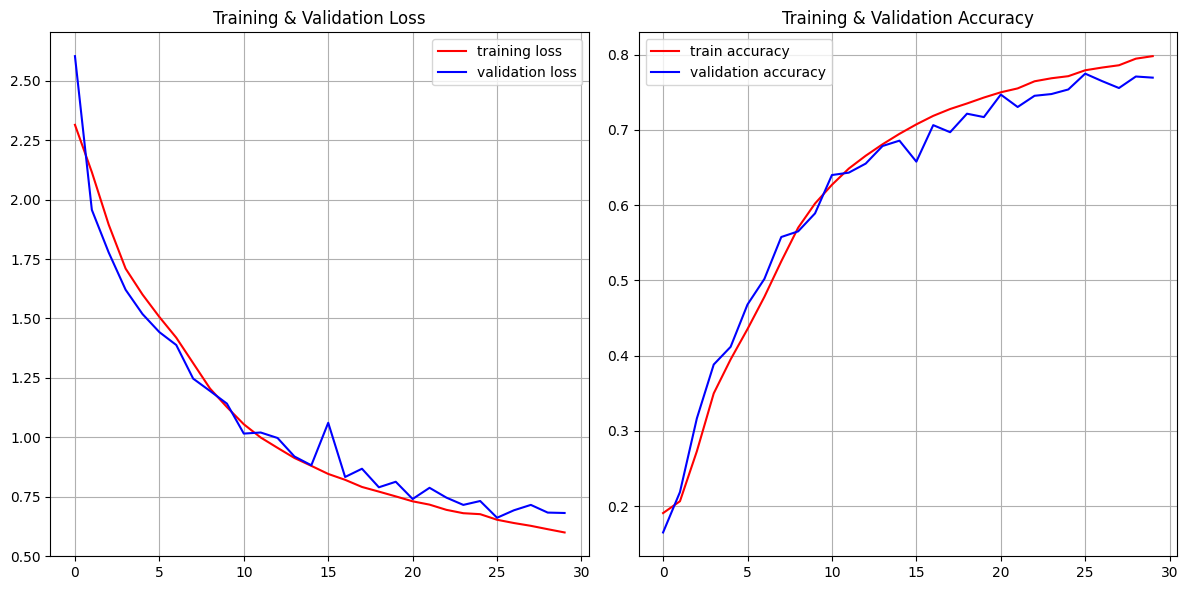

In [29]:
# mobileNet baseline
mobilenet = models.mobilenet_v2(pretrained=False)
mobilenet.classifier[1] = nn.Linear(in_features=mobilenet.classifier[1].in_features, out_features=10)
mobilenet = mobilenet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet.parameters(), lr=0.01)
model , mobilenet_metrics_1 = run_training(mobilenet, 
                               epochs=30, 
                               train_loader=train_loader, 
                               validation_loader=val_loader,
                               optimizer=optimizer, 
                               criterion=criterion, 
                               device=device,
                               patience = 10)

torch.save(model.state_dict(), 'mobilenet_Adam_baseline_model_30epochs.pth')                               
plot_loss_curves(mobilenet_metrics_1)

In [30]:
# baseline mobileNet evaluation
mobilenet = models.mobilenet_v2(pretrained=False)
mobilenet.classifier[1] = nn.Linear(in_features=mobilenet.classifier[1].in_features, out_features=10)
mobilenet.load_state_dict(torch.load('mobilenet_Adam_baseline_model_30epochs.pth')) 
mobilenet = mobilenet.to(device)
evaluate_models(mobilenet)

Test Accuracy: 75.92%


Early stopping triggered after at epoch: 27 


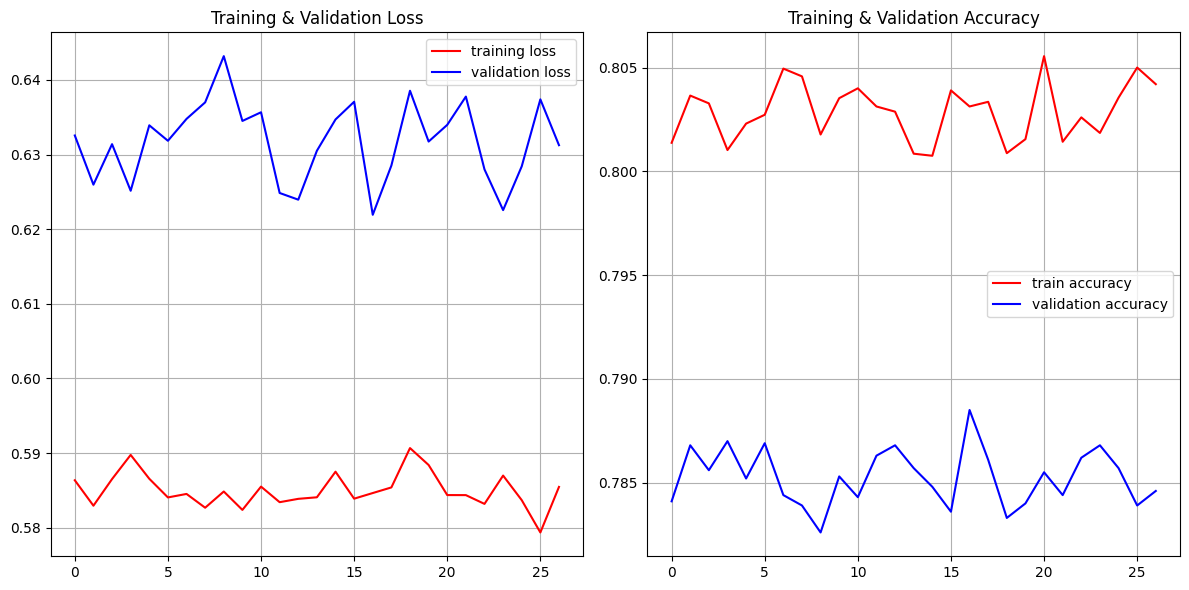

In [31]:
# mobileNet baseline additional epochs:30
mobilenet = models.mobilenet_v2(pretrained=False)
mobilenet.classifier[1] = nn.Linear(in_features=mobilenet.classifier[1].in_features, out_features=10)
mobilenet = mobilenet.to(device)
mobilenet.load_state_dict(torch.load( 'mobilenet_Adam_baseline_model_30epochs.pth'))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
model_pre_loaded , mobilenet_metrics_preloaded = run_training(mobilenet, 
                               epochs=50, 
                               train_loader=train_loader, 
                               validation_loader=val_loader,
                               optimizer=optimizer, 
                               criterion=criterion, 
                               device=device,
                               scheduler=scheduler,
                               patience = 10)
torch.save(model_pre_loaded.state_dict(), 'mobilenet_Adam_baseline_model_preloaded_base.pth') 
plot_loss_curves(mobilenet_metrics_preloaded)

In [32]:
# mobileNet baseline additional epochs:30 evaluation
mobilenet = models.mobilenet_v2(pretrained=False)
mobilenet.classifier[1] = nn.Linear(in_features=mobilenet.classifier[1].in_features, out_features=10)
mobilenet.load_state_dict(torch.load('mobilenet_Adam_baseline_model_preloaded_base.pth')) 
mobilenet = mobilenet.to(device)
evaluate_models(mobilenet)

Test Accuracy: 77.83%


Early stopping triggered after at epoch: 48 


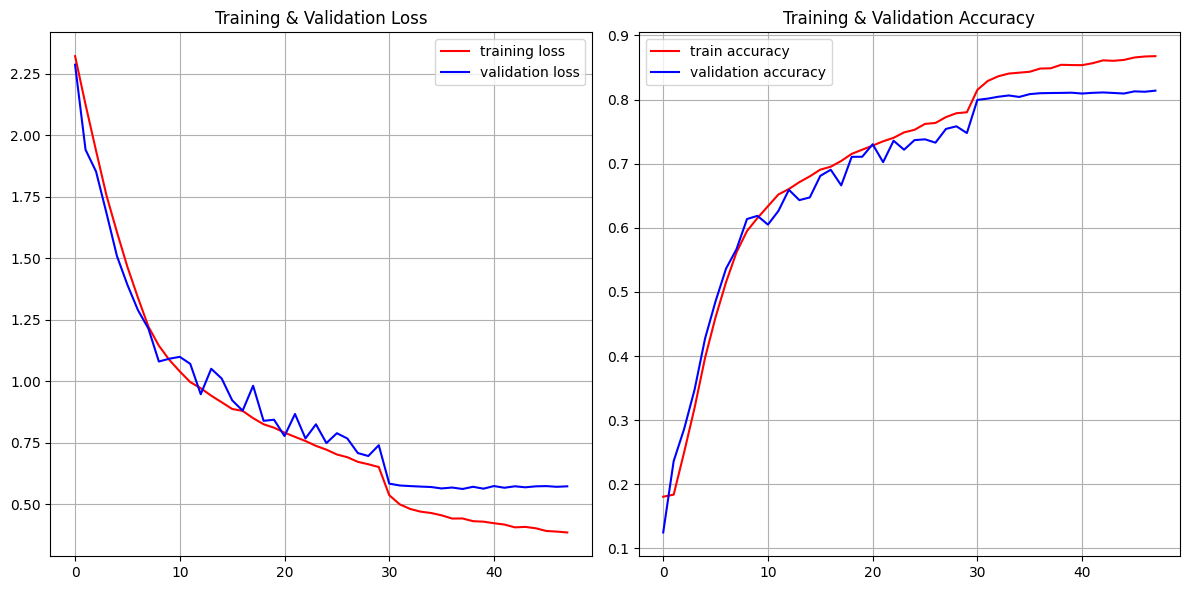

In [33]:
# mobileNet from scratch  epochs:50 with scheduler stepsize = 30
mobilenet = models.mobilenet_v2(pretrained=False)
mobilenet.classifier[1] = nn.Linear(in_features=mobilenet.classifier[1].in_features, out_features=10)
mobilenet = mobilenet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

model , mobilenet_metrics = run_training(mobilenet, 
                               epochs=50, 
                               train_loader=train_loader, 
                               validation_loader=val_loader,
                               optimizer=optimizer, 
                               criterion=criterion, 
                               device=device,
                               scheduler=scheduler,
                               patience = 10)

torch.save(model.state_dict(), 'mobilenet_Adam_baseline_model.pth')                               
plot_loss_curves(mobilenet_metrics)

In [34]:
# mobileNet from scratch  epochs:50 with scheduler stepsize = 30 evaluation
mobilenet = models.mobilenet_v2(pretrained=False)
mobilenet.classifier[1] = nn.Linear(in_features=mobilenet.classifier[1].in_features, out_features=10)
mobilenet.load_state_dict(torch.load('mobilenet_Adam_baseline_model.pth')) 
mobilenet = mobilenet.to(device)
evaluate_models(mobilenet)

Test Accuracy: 80.76%


Early stopping triggered after at epoch: 46 


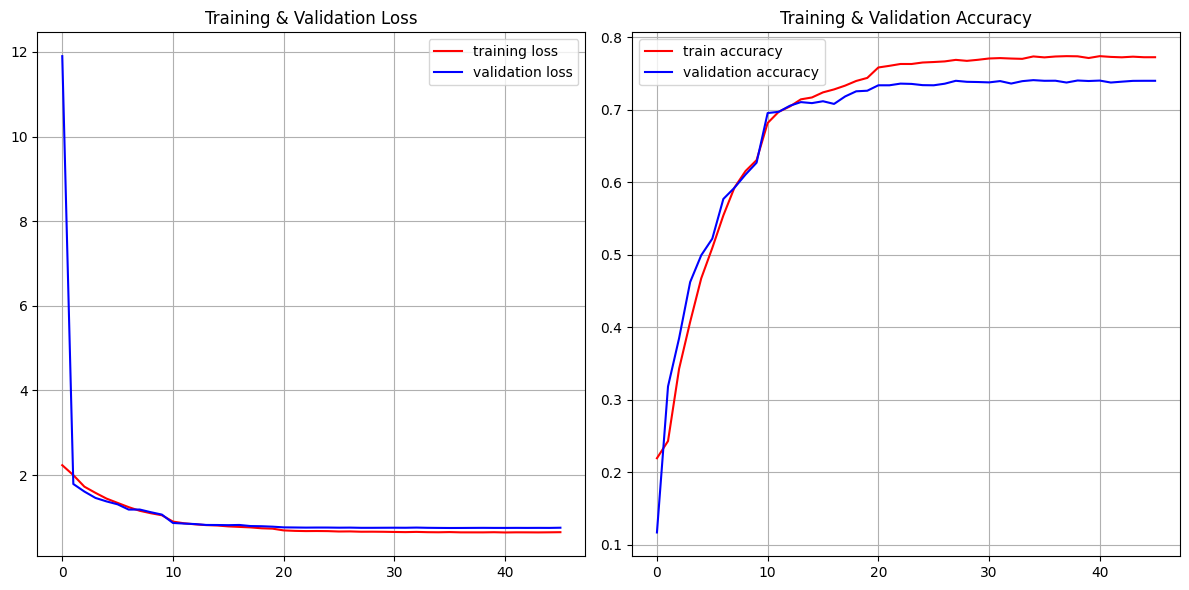

In [37]:
# mobileNet from scratch  epochs:50 with scheduler stepsize = 10
mobilenet = models.mobilenet_v2(pretrained=False)
mobilenet.classifier[1] = nn.Linear(in_features=mobilenet.classifier[1].in_features, out_features=10)
mobilenet = mobilenet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

model , mobilenet_metrics_sched_5 = run_training(mobilenet, 
                               epochs=50, 
                               train_loader=train_loader, 
                               validation_loader=val_loader,
                               optimizer=optimizer, 
                               criterion=criterion, 
                               device=device,
                               scheduler=scheduler,
                               patience = 10)

torch.save(model.state_dict(), 'mobilenet_Adam_baseline_model_sched_5.pth')                               
plot_loss_curves(mobilenet_metrics_sched_5)

In [38]:
# mobileNet from scratch  epochs:50 with scheduler stepsize = 10 evaluation
mobilenet = models.mobilenet_v2(pretrained=False)
mobilenet.classifier[1] = nn.Linear(in_features=mobilenet.classifier[1].in_features, out_features=10)
mobilenet.load_state_dict(torch.load('mobilenet_Adam_baseline_model_sched_5.pth')) 
mobilenet = mobilenet.to(device)
evaluate_models(mobilenet)

Test Accuracy: 73.97%
